In [7]:
import numpy as np 
import pandas as pd 
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch import nn
from typing import Tuple,List
from tqdm.auto import tqdm
from torch.functional import F
from PIL import Image
from IPython.display import display
from glob import glob
from itertools import product

In [8]:
class SyntheticDataset(Dataset):
    
    def __init__(self,directory:str,add_noise=True,transform=True):
            
        self.image_paths = glob(os.path.join(directory, '*.jpeg'))
        self.add_noise   = add_noise
        self.transform   = transform 
        
        
    def __len__(self):
        
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        
        if self.transform:
            image = transforms.Compose([
                               transforms.Resize(320),
                               transforms.CenterCrop(160),
                               transforms.ToTensor(),
                           ])(image)
        image = torch.sum(image,dim=0)/3
        size = image.size()
        
        if self.add_noise:
            
            stdw  = (0 - 0.05) * torch.rand(1) + 0.05
            noise = torch.normal(0,float(np.abs(stdw)),size)
            image = image + noise
            
        
        return image

In [9]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
synthetic_root = "/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/synthetic/Denemeler/"
batch_size = 8

In [10]:
synthetic_data = SyntheticDataset(synthetic_root)

In [11]:
sloader = DataLoader(synthetic_data, batch_size=batch_size,shuffle=True)

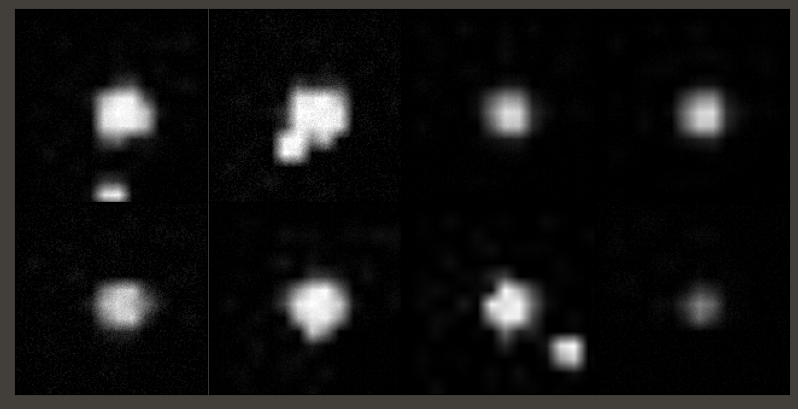

In [13]:
idx, data = next(enumerate(sloader))

_, axes = plt.subplots(nrows=2,ncols=4,figsize=(10,5))

for i, (row,col) in enumerate(product(range(2),range(4))):

    axes[row][col].imshow(data[i],clim=(0,1),cmap='gray')
    #print(data[i].shape)
    axes[row][col].set_yticks([])
    axes[row][col].set_xticks([])
    

_.patch.set_facecolor('#423f3b')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()       

In [6]:
class VAE(nn.Module):
    
    def __init__(self,in_channels:int,image_size:int,batch_size:int,latent_size:int=200):
        super(VAE,self).__init__()
        
        self.C = 32
        self.in_channels = in_channels
        self.image_size  = image_size
        self.latent_size = latent_size
        self.batch_size  = batch_size
        
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=self.in_channels,out_channels=self.C,stride=1,kernel_size=5), 
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=self.C,out_channels=self.C,stride=1,kernel_size=3),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=self.C,out_channels=self.C,stride=2,kernel_size=4), 
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=self.C,out_channels=self.C*2,stride=1,kernel_size=3),
            nn.LeakyReLU(),
            
        )
        
        self.mean    = nn.Linear(5476,self.latent_size)
        self.log_var = nn.Linear(5476,self.latent_size)
            
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.C*2,out_channels=self.C,stride=1,kernel_size=3), 
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=self.C,out_channels=self.C,stride=2,kernel_size=4), 
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=self.C,out_channels=self.C,stride=1,kernel_size=3),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=self.C,out_channels=self.in_channels,stride=1,kernel_size=5),
        )
        
    def reparameterize(self,z_mean,z_log_var):
        
        eps = torch.randn(z_mean.size(0),z_mean.size(1)).to(device)
        z = z_mean + torch.exp(z_log_var/2) * eps
        
        return z
    
            
    def forward(self, x):
        
        #[160, 156, 154, 76, 74] encoder dims
        #[74, 76, 154, 156, 160] decoder dims
        
        x = x.view(x.size(0),1,160,160)
        x = self.encoder(x)
        x = x.view(x.size(0),-1)
        
        
        mean = self.mean(x)
        logv = self.log_var(x)
        
        
        z = self.reparameterize(mean,logv)
        
        encoded = z.view(z.size(0),1,74,74)
        
        x = self.decoder(z)
        
        return x, z, mean, logv

In [7]:
def vae_loss(x_hat,x,mean,logv):
    
    x = x.view(x.size(0),-1).to(device)
    recons = F.mse_loss(x_hat, x, reduction='mean')
    kl = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp())
    
    return recons + kl 

In [8]:
def train(model,train_dataloader,optimizer,device,loss_fn,EPOCH=30):
    
    with tqdm(total = len(train_dataloader) * EPOCH) as tt:
        
        model.train()
        
        for epoch in range(EPOCH):
            
            total_loss, batch_count = 0, 0
            
            for idx,(batch,_) in enumerate(train_dataloader):
                
                x, z, mean, logv = model(batch.to(device))
                
                loss = loss_fn(x,batch,mean,logv)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
                total_loss += loss.item()
                batch_count += 1
                tt.update()
                
            total_loss = total_loss / batch_count
            print(f'{total_loss}')

In [ ]:
#model = VAE(in_channels=1,image_size=image_size,batch_size=batch_size)
#model = model.to(device)

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)  

In [ ]:
#train(model=model,train_dataloader=sloader,optimizer=optimizer,loss_fn=vae_loss,device=device,EPOCH=20)